## Business Mathematics - Data Analysis with Python, Project 2

## SVD Classification of Handwritten Digits 

### Angelos Semoglou, s3332318

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings 

# To suppress warnings related to any (irrelevant) unsupported extensions in the excel file
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# sklearn.metrics:
# - accuracy_score: ratio of correctly predicted instances to the total instances
# - confusion_matrix: table/matrix that shows the number of true positive, true negative,
#   false positive and false negative predictions
# - classification_report: generates a text report showing the main classification metrics,
#   icluding precision, recall and f1

### Data Preparation 

In [2]:
# Load Data using Pandas
data_file = pd.ExcelFile("data.xlsx")

# Parse sheets of training and testing data (& their digits) into data frames
azip, dzip = data_file.parse("azip", header=None), data_file.parse("dzip", header=None)
testzip, dtest = data_file.parse("testzip", header=None), data_file.parse("dtest", header=None)

# Convert to transposed numpy arrays to manipulate the data
# Training data (images) and the digits (numbers) corresponding to the training data
train_data, train_digits = np.asarray(azip).T, np.asarray(dzip).T
# Testing data (images) and the digits (numbers) corresponding to the testing data
test_data, test_digits = np.asarray(testzip).T, np.asarray(dtest).T

### Methods - Functions

In [3]:
def perform_trunc_svd(k, data):
    """
    Perform truncated Singular Value Decomposition on the input data.

    Parameters:
    - k: The number of components to retain.
    - data: Input data (matrix) for SVD.

    Returns:
    - U_k: Left k singular vectors.
    - S_k: Singular k values.
    - Vt_k: Right k singular vectors.
    """
    U, S, Vt = linalg.svd(np.asarray(data).T, check_finite=False)
    U_k = U[:, 0:k] # Retain the first k left singular vectors
    S_k = S[0:k] # Retain the first k singular values
    Vt_k = Vt[0:k,:] # Retain the first k right singular vectors
    
    return U_k, S_k, Vt_k

In [4]:
def digits_data_dict(data, digits):
    """
    Create a dictionary where keys are digits (0-9) and values are lists of corresponding data samples.

    Parameters:
    - data: Input data samples.
    - digits: Numbers/Labels corresponding to the input data.

    Returns:
    - dig_dat_dict: A dictionary where each key is a digit, and the 
                    corresponding value is a list of data samples associated with that digit.
    """
    digits_data_dict = {}
    
    for i, digit in enumerate(list(digits)):
        digit = int(digit)
        
        # Check if the digit is already a key in the dictionary
        if digit in digits_data_dict.keys():
            digits_data_dict[digit].append(data[i])
        else:
            # If not, create a new key with the digit and initialize a list with the data sample
            digits_data_dict[digit] = [data[i]]
            
    return digits_data_dict

In [5]:
def trunc_svd_for_digits(digit_data_dict):
    """
    Compute truncated SVD per digit and for each number of basis vectors (1 to 20).

    Parameters:
    - digit_data_dictionary: The output from digit_data_dictionary function.

    Returns:
    - svd_results: A dictionary where keys are the components (number of basis vectors) (1-20)
                  and the corresponding values are dictionaries with keys - the digits,
                  and values - the left singular vectors of each truncated SVD.
    """
    svd_results = {}
    
    # Iterate over the number of basis vectors (1 - 20)
    for k in range(1, 21):
        k_dict = {}
        
        # Iterate over the digits(=dictionary keys), sorted for consistent order
        for digit in sorted(digit_data_dict.keys()): 
            data = digit_data_dict[digit]
            U_digit_k, S_digit_k, Vt_digit_k = perform_trunc_svd(k, data)
            k_dict[digit] = U_digit_k
        svd_results[k] = k_dict
        
    return svd_results

In [6]:
def classify_with_svd(data, num_components, svd_results):
    """
    Classify digits using SVD.

    Parameters:
    - data: (Test) Data for which predictions are made.
    - num_components: Number of basis (singular) vectors to use in classification.
    - svd_results: Output of truncated_svd_for_digits function.

    Returns:
    - A list of predicted digits for each test (data) element.
    """
    predictions = [] # List for digit predictions
    identity = np.eye(256) # Identity matrix to use in residual calculations
    # Iterate through every element (sample) in the data
    for element in data:
        lstq_residuals = [] # List for least squares residuals
        
        # Iterate through each digit's truncated SVD result
        for digit in svd_results[num_components].keys():
            U_digit_k = svd_results[num_components][digit]
            residual = np.dot(identity - np.dot(U_digit_k, U_digit_k.T), element)
            relative_residual = norm(residual) / norm(element)
            lstq_residuals.append(relative_residual)
            
        # Clasify as the digit with the smallest residual
        predicted_digit = lstq_residuals.index(min(lstq_residuals))
        predictions.append(predicted_digit)
        
    return predictions

In [7]:
def classify_with_svd_custom(data, num_components, svd_results, custom_component, specific_digit):
    """
    Classify digits using SVD with custom adjustments for specific digits.

    Parameters:
    - data: (Test) Data for which predictions are made.
    - num_components: Number of basis (singular) vectors to use in classification.
    - svd_results: Output of truncated_svd_for_digits function.
    - custom_component: Number of basis (singular) vectors for the classification of specific digits.
    - specific_digit: The specific digit

    Returns:
    - A list of predicted digits for each test (data) element (sample).
    """
    predictions = [] 
    identity = np.eye(256)
    for element in data:
        lstq_residuals = []
        for digit in svd_results[num_components].keys():
            if digit == specific_digit:
                U_digit_k = svd_results[custom_component][digit]
            else:
                U_digit_k = svd_results[num_components][digit]
            residual = np.dot(identity - np.dot(U_digit_k, U_digit_k.T), element)
            relative_residual = norm(residual) / norm(element)
            lstq_residuals.append(relative_residual)
        predicted_digit = lstq_residuals.index(min(lstq_residuals))
        predictions.append(predicted_digit)
        
    return predictions

In [8]:
def display_images(digit, digit_data_dict):
    """
    Display the first 15 digits from a class in a 3-column grid.

    Parameters:
    - digit: The digit for which images will be displayed.
    - digit_data_dictionary: A dictionary with values as lists of data samples (keys=digits)
    """
    for image_index in range(0, 15, 3):
        # Create a subplot with 1 row and 3 columns for displaying 3 images side by side 
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(8,8), ncols = 3)
        
        for i, ax in enumerate([ax1, ax2, ax3]):
            if image_index + i < 15:
                
                # Display each image
                image = digit_data_dict[digit][image_index + i].reshape(16, 16)
                
                # Normalize pixel values: scale to [0, 20]
                image = (image - min(image.ravel())) * np.ones(image.shape)
                image = (20/max(image.ravel()))*image
                ax.imshow(np.uint8(image.reshape(16, 16)), cmap = 'gray')
                
        plt.show()

In [9]:
def plot_accuracy(accuracy_data, basis_vectors, type_of_data_set):
    """
    Print Maximum Accuracy and 
    Plot the percentage of correctly classified digits as a function of the number of basis vectors.

    Parameters:
    - accuracy_data: List of accuracy values.
    - basis_vectors: List of the number of basis vectors
    - type_of_data_set: A string indicating the type of data set ("Training"/"Test")
    """
    # Find the maximum accuracy in the provided data
    max_acc = max(accuracy_data) 
    # Find the position of the maximum accuracy in the list
    max_acc_position = accuracy_data.index(max_acc) 
    # Get the number of basis vectors corresponding to the maximum accuracy
    number_of_basis_vectors = basis_vectors[max_acc_position] 
    print(
    f'\nMaximum Accuracy on {type_of_data_set} Data set is achieved with '
    f'{number_of_basis_vectors} Basis Vectors (Accuracy: {max_acc:.4f})'
    )
    # Plot
    plt.figure()
    plt.grid(linestyle = '--')
    plt.xlabel('Number of Basis Vectors')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy - Number of Basis Vectors on {type_of_data_set} Data Set')
    # Scatter plot marker at the point of maximum accuracy in red
    plt.scatter([number_of_basis_vectors], [max_acc],
                color = 'red',
                marker = 'o',
                s = 100,
                label = 'Maximum Accuracy')
    
    # Annotate the maximum accuracy point with its coordinates
    plt.text(number_of_basis_vectors-0.3,
             max_acc,
             f'({number_of_basis_vectors}, {max_acc:.4f})',
             color='red',
             fontsize=9.5,
             ha='right', va='bottom')
    
    plt.plot(basis_vectors, accuracy_data, marker = 'o', color='black', markersize = 5.5)
    plt.legend()
    plt.show()

In [10]:
def report(num_cust_vectors, spec_digit):
    """
    Print Classification Report - Quality of Predictions for classify_with_svd_custom function.
    
    Patameters:
    - num_cust_vectors: Number of basis vectors for the classification of a specific digit.
    - spec_digit: Specific Digit.
    
    (Parameters used in classify_with_svd_custom algorithm)
    """
    print(f"\nEvaluate classification performance with {num_cust_vectors} basis vectors for digit {spec_digit}\n")
    
    # Make predictions using classify_with_svd_custom algorithm
    prediction = classify_with_svd_custom(test_data, 15, svd_results, num_cust_vectors, spec_digit)
    
    # Get the unique digits in the test data
    digits = sorted(set(list(test_digits.ravel())))
    classification_r = classification_report(test_digits, prediction) # Generate a classification report
    print('\n------------------ Classification report ------------------\n\n',classification_r)
    accuracy = accuracy_score(test_digits.ravel(), prediction)
    print('\nAccuracy:', accuracy)

### Question 1. Accuracy of Classification

In [11]:
# Data Preparation: Create a dictionary where keys are digits (0-9), 
# and values are lists of corresponding training data sample
digits_data_train_dict = digits_data_dict(train_data, train_digits)

# Singular Value Decomposition (SVD) for Digits: Compute truncated SVD 
# for each digit class and for each specified number of basis vectors
svd_results = trunc_svd_for_digits(digits_data_train_dict)

# Evaluate Classification Accuracy for Different Numbers of Basis Vectors
test_accuracy = [] # List to store test accuracy values 
train_accuracy = [] # List to store training accuracy values

# Iterate over a range of basis vectors (from 5 to 20)
for num_vectors in range(5, 21):
    # Classify training and test data using SVD with num_vectors basis vectors
    train_digits_prediction = classify_with_svd(train_data, num_vectors, svd_results)
    test_digits_prediction = classify_with_svd(test_data, num_vectors, svd_results)
     
    # Calculate and print accuracy for test data
    train_accuracy_value = accuracy_score(train_digits_prediction, train_digits.ravel())
    test_accuracy_value = accuracy_score(test_digits_prediction, test_digits.ravel())
    print(f'With {num_vectors} SVD basis vectors, accuracy is {test_accuracy_value:.4f}\n')

    # Append accuracy values to lists for later analysis
    test_accuracy.append(test_accuracy_value)
    train_accuracy.append(train_accuracy_value)

With 5 SVD basis vectors, accuracy is 0.9028

With 6 SVD basis vectors, accuracy is 0.9053

With 7 SVD basis vectors, accuracy is 0.9168

With 8 SVD basis vectors, accuracy is 0.9203

With 9 SVD basis vectors, accuracy is 0.9263

With 10 SVD basis vectors, accuracy is 0.9317

With 11 SVD basis vectors, accuracy is 0.9322

With 12 SVD basis vectors, accuracy is 0.9357

With 13 SVD basis vectors, accuracy is 0.9362

With 14 SVD basis vectors, accuracy is 0.9392

With 15 SVD basis vectors, accuracy is 0.9412

With 16 SVD basis vectors, accuracy is 0.9387

With 17 SVD basis vectors, accuracy is 0.9392

With 18 SVD basis vectors, accuracy is 0.9417

With 19 SVD basis vectors, accuracy is 0.9407

With 20 SVD basis vectors, accuracy is 0.9397




Maximum Accuracy on Train Data set is achieved with 20 Basis Vectors (Accuracy: 0.9959)


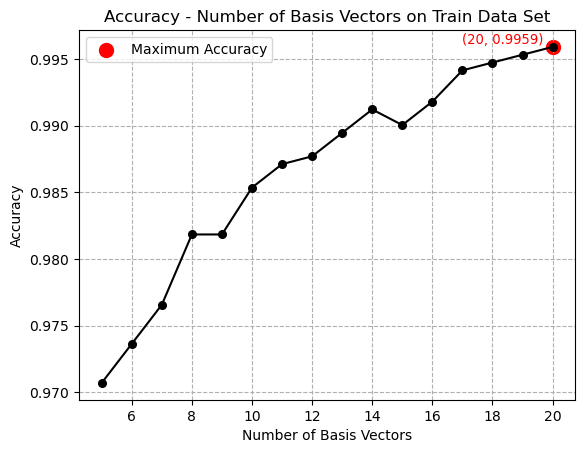


Maximum Accuracy on Test Data set is achieved with 18 Basis Vectors (Accuracy: 0.9417)


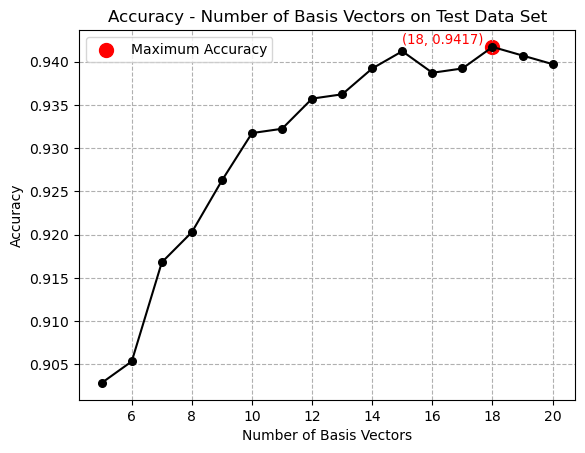

In [12]:
basis_vectors = np.arange(5, 21, 1)

# Plot the accuracy on the training data as a function of the number of basis vectors.
plot_accuracy(train_accuracy, basis_vectors, "Train")

# Plot the accuracy on the test data as a function of the number of basis vectors.
plot_accuracy(test_accuracy, basis_vectors, "Test")

### Question 2. Difficult Classification Digits

In [13]:
# Classify test data using SVD with 11 basis vectors
test_prediction = classify_with_svd(test_data, 11, svd_results)

# Find the digits that are challenging to classify by identifying
# the indices of the minimum diagonal values in the confusion matrix
cm = confusion_matrix(test_digits, test_prediction)
diag_elements_of_cm = [] # Diagonal elements of the confusion matrix

# Extract diagonal elements of the confusion matrix
for i in range(10):
    diag_elements_of_cm.append(cm[i,i])
    
three_minimum_indices = [] # Indices of the three smallest diagonal values 

# Find the three smallest values and their indices
for i in range(3):
    element = min(diag_elements_of_cm)
    element_index = diag_elements_of_cm.index(element)
    three_minimum_indices.append(element_index)
    diag_elements_of_cm[element_index] = float('inf') 

print('\nMost difficult digit to classify:',three_minimum_indices[0])
print('\nSecond most difficult digit to classify:',three_minimum_indices[1])
print('\nThird most difficult digit to classify:',three_minimum_indices[2], '\n\netc.')
print('\nWe will plot images of the two most difficult digits to classify\n'
      'and observe that, in most cases, they are very badly written.')


Most difficult digit to classify: 7

Second most difficult digit to classify: 5

Third most difficult digit to classify: 3 

etc.

We will plot images of the two most difficult digits to classify
and observe that, in most cases, they are very badly written.



Digit: 7


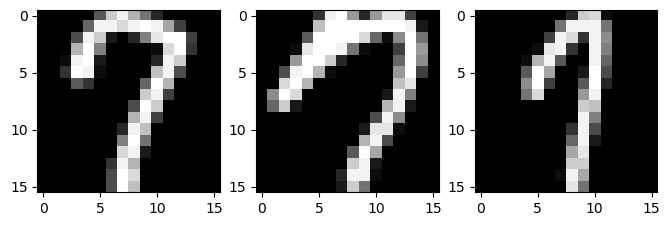

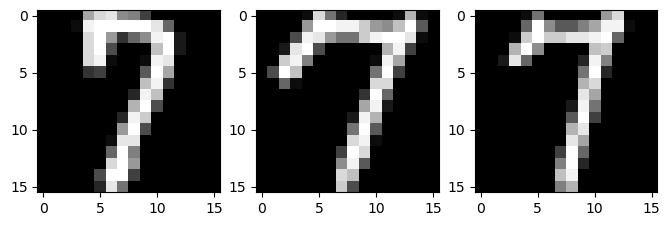

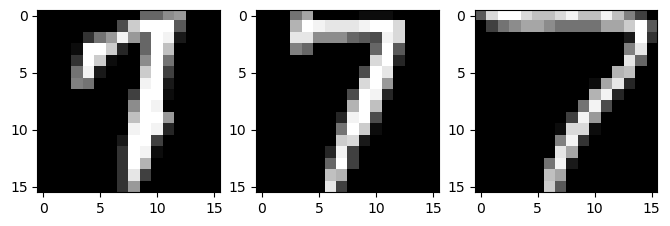

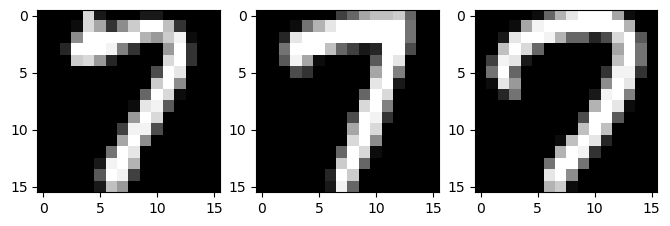

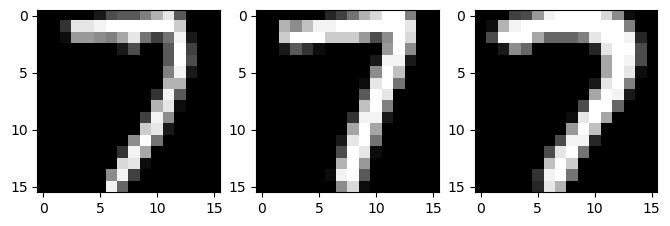

In [14]:
print('\nDigit:',three_minimum_indices[0])
display_images(three_minimum_indices[0], digits_data_train_dict)


Digit: 5


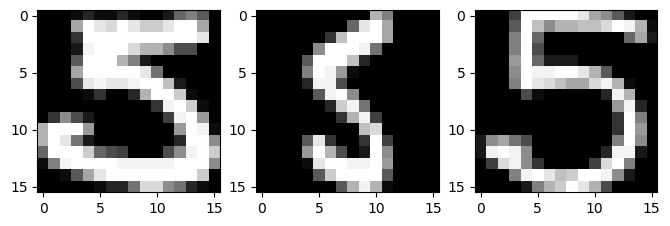

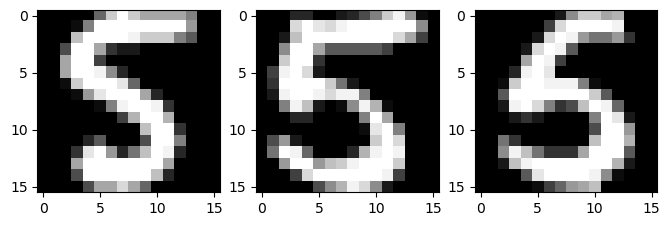

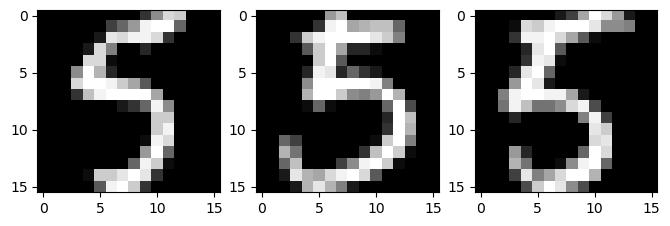

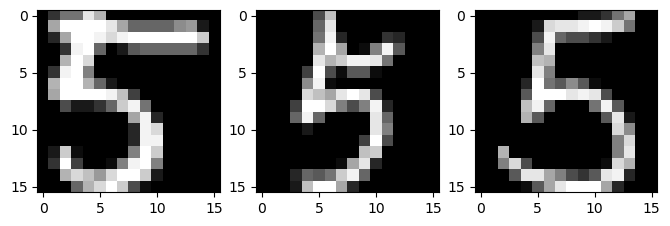

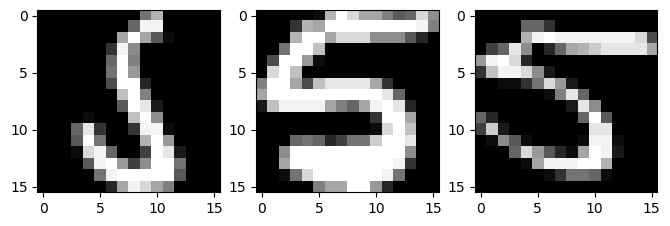

In [15]:
print('\nDigit:',three_minimum_indices[1])
display_images(three_minimum_indices[1], digits_data_train_dict)

### Question 3. Custom Classification 

In [16]:
# Print the singular values for each digit using truncated SVD with 10 basis vectors
print('\nSingular Values:\n')
for digit in range(0, 10):
    print(digit, perform_trunc_svd(10, digits_data_train_dict[digit])[1],'\n')

print('\nWe observe that in the class 1, the first singular value is higher than the others\n')
print('We will use different numbers of basis vectors for that class\n')


Singular Values:

0 [184.44749844  97.59388422  62.05061337  54.14931248  41.06020067
  40.36847138  36.28294233  30.02308652  29.00107349  24.94954536] 

1 [234.04151731  41.9309063   24.84924265  16.29480667  13.61095501
  12.52178131  11.22883717  10.66849318   8.4133817    8.32127045] 

2 [138.2836996   57.39739384  46.39569635  40.96003126  37.50530652
  33.53160003  32.237997    28.40611951  27.12012507  26.73498766] 

3 [126.63823606  39.77367291  33.32245701  29.87372361  27.9646299
  24.76781289  24.39030584  21.460863    19.05978766  18.59508072] 

4 [123.02706507  41.62602412  34.93431159  32.29075793  26.81182829
  24.5655462   21.86754262  20.44929199  20.08172813  18.45554627] 

5 [94.28412631 37.85299086 35.77494073 28.02067178 24.0466634  22.43784723
 20.63123172 20.36365239 17.06151968 16.81156101] 

6 [141.95961664  52.1946615   37.96584617  32.01451394  26.28505545
  25.13724003  21.2005021   20.93588569  19.34289072  18.88883469] 

7 [160.19698391  46.71035896  36.

In [17]:
report(1, 1)


Evaluate classification performance with 1 basis vectors for digit 1


------------------ Classification report ------------------

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       1.00      0.84      0.91       264
           2       0.95      0.90      0.93       198
           3       0.90      0.89      0.90       166
           4       0.85      0.93      0.89       200
           5       0.91      0.88      0.90       160
           6       0.93      0.95      0.94       170
           7       0.93      0.97      0.95       147
           8       0.87      0.92      0.90       166
           9       0.93      0.95      0.94       177

    accuracy                           0.92      2007
   macro avg       0.92      0.92      0.92      2007
weighted avg       0.93      0.92      0.92      2007


Accuracy: 0.924265072247135


In [18]:
report(2, 1)


Evaluate classification performance with 2 basis vectors for digit 1


------------------ Classification report ------------------

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       1.00      0.91      0.95       264
           2       0.95      0.90      0.93       198
           3       0.90      0.89      0.90       166
           4       0.88      0.93      0.91       200
           5       0.91      0.88      0.90       160
           6       0.93      0.95      0.94       170
           7       0.93      0.97      0.95       147
           8       0.93      0.92      0.93       166
           9       0.93      0.95      0.94       177

    accuracy                           0.93      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.93      0.93      0.93      2007


Accuracy: 0.9332336821126059


In [19]:
report(3, 1)


Evaluate classification performance with 3 basis vectors for digit 1


------------------ Classification report ------------------

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       1.00      0.92      0.96       264
           2       0.95      0.90      0.93       198
           3       0.90      0.89      0.90       166
           4       0.89      0.93      0.91       200
           5       0.91      0.88      0.90       160
           6       0.94      0.95      0.95       170
           7       0.93      0.97      0.95       147
           8       0.94      0.92      0.93       166
           9       0.93      0.95      0.94       177

    accuracy                           0.94      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.94      0.94      0.94      2007


Accuracy: 0.9357249626307922


In [20]:
report(4, 1)


Evaluate classification performance with 4 basis vectors for digit 1


------------------ Classification report ------------------

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       1.00      0.93      0.96       264
           2       0.95      0.90      0.93       198
           3       0.90      0.89      0.90       166
           4       0.89      0.93      0.91       200
           5       0.91      0.88      0.90       160
           6       0.95      0.95      0.95       170
           7       0.93      0.97      0.95       147
           8       0.94      0.92      0.93       166
           9       0.93      0.95      0.94       177

    accuracy                           0.94      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.94      0.94      0.94      2007


Accuracy: 0.9367214748380668


In [21]:
report(5, 1)

print('\n\nIn our experiments, we noticed that, especially for digit 1,\n'
    'using fewer basis vectors can maintain accuracy levels. The last three experiments\n'
    'demonstrate almost stable accuracy even with a reduced number of basis vectors\n')


Evaluate classification performance with 5 basis vectors for digit 1


------------------ Classification report ------------------

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       1.00      0.94      0.96       264
           2       0.95      0.90      0.93       198
           3       0.90      0.89      0.90       166
           4       0.89      0.93      0.91       200
           5       0.91      0.88      0.90       160
           6       0.95      0.95      0.95       170
           7       0.93      0.97      0.95       147
           8       0.94      0.92      0.93       166
           9       0.93      0.95      0.94       177

    accuracy                           0.94      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.94      0.94      0.94      2007


Accuracy: 0.9372197309417041


In our experiments, we noticed that, especially for digit 1,
using fewer ba

### Optional Task: Two-Stage Algorithm with SVD

In [22]:
def classify_with_two_stage_svd(data, num_components, svd_results, threshold):
    """
    Classify handwritten digits using a two-stage algorithm based on Singular Value Decomposition (SVD).

    Parameters:
    - data: (Test) Data for which predictions are made.
    - num_components: Number of basis vectors to consider in the first stage.
    - svd_results: Dictionary containing SVD results per digit for each component.
    - threshold: Threshold for considering the first stage as successful.

    Returns:
    - prediction: Predicted digits for each element - data sample.
    - unnecessary_second_stage_count: Number of times the second stage is unnecessary.
    """

    identity = np.eye(256) 
    prediction = []  
    unnecessary_second_stage_count = 0  # Counter for unnecessary second stages

    for element in data:
        lstq_residuals = []

        # First Stage: Compare with the first singular vector in each class
        for digit in svd_results[num_components].keys():
            U_digit_k = svd_results[num_components][digit]
            residual = np.dot(identity - np.dot(U_digit_k[:, :1], U_digit_k[:, :1].T), element)
            relative_residual = norm(residual) / norm(element)
            lstq_residuals.append(relative_residual)
        # If for one class the residual is significantly smaller than for the others, classify as that class.
        if norm(np.diff(sorted(lstq_residuals)[:2])) > threshold:
            predicted_digit = lstq_residuals.index(min(lstq_residuals))
            prediction.append(predicted_digit)
            unnecessary_second_stage_count += 1
            continue
        # Second Stage: Use the original algorithm (classify_with_svd)
        second_stage_predictions = classify_with_svd([element], num_components, svd_results)
        predicted_digit = second_stage_predictions[0]
        prediction.append(predicted_digit)
    return prediction, unnecessary_second_stage_count

# Test the two-stage algorithm on the test data
two_stage_test_predictions, unnecessary_second_stage_count = classify_with_two_stage_svd(test_data, 10, svd_results, 0.1)
# Use the original algorithm (classify_with_svd) as a baseline for comparison
one_stage_test_predictions = classify_with_svd(test_data, 10, svd_results)

accuracy_one_stage = accuracy_score(one_stage_test_predictions, test_digits.ravel())
accuracy_two_stage = accuracy_score(two_stage_test_predictions, test_digits.ravel())

print('\nExample with basis vectors: 10 and threshold: 0.1\n')
print('Accuracy with One-Stage Algorithm:', accuracy_one_stage)
print('\nAccuracy with Two-Stage Algorithm:', accuracy_two_stage)
print('Number of Unnecessary Second Stages:', unnecessary_second_stage_count)


Example with basis vectors: 10 and threshold: 0.1

Accuracy with One-Stage Algorithm: 0.931738913801694

Accuracy with Two-Stage Algorithm: 0.9287493771798705
Number of Unnecessary Second Stages: 1030
